# Librairies

In [2]:
import pandas as pd 
import geopandas as gpd
import matplotlib.pylab as plt
import contextily as cx

# Referential

In [127]:
gdf = pd.read_csv('raw/stm2023.csv', delimiter=';' ,encoding = 'latin')

In [128]:
gdf = gpd.GeoDataFrame(
    gdf,
    geometry=gpd.points_from_xy(gdf['Koordinata E'], gdf['Koordinata N']),
    crs = 'epsg:3794'
).to_crs('epsg:4326')

In [129]:
# Clip to the city
# We have data for the entire Estonia, let's keep only Tallinn
cities = gpd.read_file('../../assets/world_urban_areas/World_Urban_Areas.geojson')
mask = cities[cities.Name == 'Ljubljana'].geometry.values[0]
# Extend a bit the mask
gdf = gdf.clip(mask.buffer(.1))

(14.326000213623043, 14.765555901058805, 45.890193407531875, 46.25596551178063)

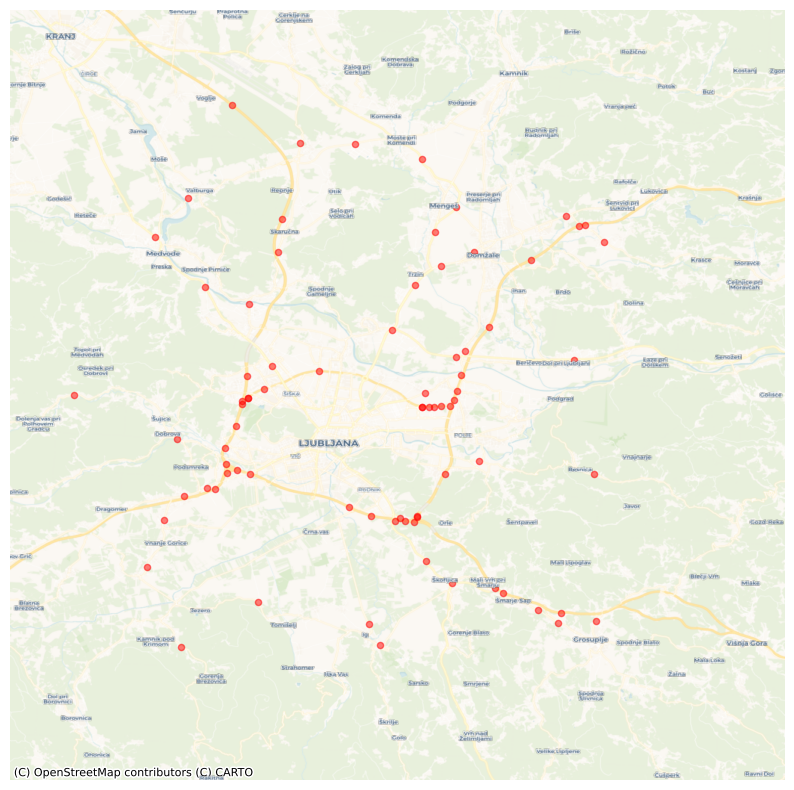

In [54]:
# Plot sensors
ax = gdf.plot(color = 'r', markersize = 20, alpha = .5, figsize = (10,10))
# Add context in backround
cx.add_basemap(ax, crs = gdf.crs, source=cx.providers.CartoDB.VoyagerNoLabels)

cx.add_basemap(ax, crs = gdf.crs, source=cx.providers.CartoDB.VoyagerOnlyLabels)

# Remove lat lon
plt.axis('off')
plt.axis('auto')

In [130]:
gdf.columns = [
    "Counting location",
    "Road number",
    "Section number",
    "Counting point",
    "Name of the counting location",
    "Counting type",
    "Counts one direction",
    "Year of manual (auto) counting",
    "Coordinate E",
    "Coordinate N",
    "geometry"
]


# Load traffic data

In [131]:
df = pd.read_csv('raw/pldp2023noo.csv', delimiter = ';', encoding='latin', skipfooter=19, thousands='.')
print(df.columns)
df.columns = [
    "Road category", 
    "Road number", 
    "Section number", 
    "Traffic section", 
    "Start station", 
    "End station", 
    "Counting location", 
    "Name of the counting location", 
    "Counting type", 
    "All vehicles (AADT)", 
    "Motorcycles", 
    "Passenger cars", 
    "Buses", 
    "Light trucks < 3.5t", 
    "Medium trucks 3.5-7t", 
    "Heavy trucks > 7t", 
    "Trucks with trailers", 
    "Semi-trailers", 
    "Daily NOO", 
    "Type"
] # From chatgpt
df.tail()

Index(['Kat. ceste', 'tev. ceste', 'tev. odseka', 'Prometni odsek',
       'Stac. zaèetka', 'Stac. konca', 'tevno mesto', 'Ime tevnega mesta',
       'Tip   tetja', 'Vsa vozila (PLDP)', 'Motorji', 'Osebna vozila',
       'Avtobusi', 'Lah. tov.  < 3,5t', 'Sr. tov.  3,5-7t', 'Te. tov. nad 7t',
       'Tov. s prik.', 'Vlaèilci', 'Dnevni NOO', 'Tip'],
      dtype='object')


,Road category,Road number,Section number,Traffic section,Start station,End station,Counting location,Name of the counting location,Counting type,All vehicles (AADT),Motorcycles,Passenger cars,Buses,Light trucks < 3.5t,Medium trucks 3.5-7t,Heavy trucks > 7t,Trucks with trailers,Semi-trailers,Daily NOO,Type
1217,RT,940,1018,MATAVUN - VREME,0,3707,207.0,Vreme,MWTC1,775,17,629,5,92,9,22,0,1,16,PLDP
1218,RT,940,3214,ZAVRHEK - ARTVIE,0,14830,589.0,Zavrhek,MWTC1,390,1,323,0,38,18,10,0,0,9,PLDP
1219,RT,940,3214,ARTVIE - PREGARJE,14830,23588,593.0,Pregarje-4,MWTC1,290,1,275,4,7,1,2,0,0,3,PLDP
1220,RT,940,3213,PREGARJE - HARIJE,0,7696,591.0,Pregarje-2,MWTC1,345,13,299,5,16,8,4,0,0,6,PLDP
1221,RT,941,1541,GRABONO - RADENCI,0,7399,343.0,Kapelski Vrh,QLTC10,2103,31,1883,11,154,10,9,3,2,15,PLDP


In [132]:
# Convert Section number like in df
gdf['Section number'] = ['0'*(4-len(x)) + x  for x in gdf['Section number'].astype('int').astype('str')]

In [133]:
gdf.shape

(79, 11)

In [134]:
# Filter the measurements which are in gdf
df = df[df['Section number'].isin(gdf['Section number'])]
df.shape

(92, 20)

In [135]:
df.dropna(subset = ['Counting location'], inplace=True)
df['Counting location'] = df['Counting location'].astype('int')

In [136]:
df.head()

,Road category,Road number,Section number,Traffic section,Start station,End station,Counting location,Name of the counting location,Counting type,All vehicles (AADT),Motorcycles,Passenger cars,Buses,Light trucks < 3.5t,Medium trucks 3.5-7t,Heavy trucks > 7t,Trucks with trailers,Semi-trailers,Daily NOO,Type
37,AC,A1,0143,PRIKLJ. KRTINA,0,340,851,Priklj. Krtina-CE,QLTC8,2008,5,1530,19,189,89,16,33,127,174,PLDP
38,AC,A1,0143,PRIKLJ. KRTINA,340,761,835,Priklj. Krtina-LJ,QLTC8,5569,39,4824,3,461,51,38,14,139,154,PLDP
39,AC,A1,0045,KRTINA - DOMALE,0,3505,1045,Domale AC,QLTC8,52902,224,39222,242,5922,638,374,874,5406,5531,PLDP
40,AC,A1,0046,DOMALE - ENTJAKOB,0,5381,830,Pata AC,QLTC8,61212,189,47002,248,6601,640,377,852,5303,5439,PLDP
42,AC,A1,0047,SNEBERJE - LJ (ZADOBRAVA),1159,2394,2401,Sneberje AC,QLTC8,70543,260,55504,284,6645,898,545,967,5440,5802,PLDP


In [137]:
gdf.head()

,Counting location,Road number,Section number,Counting point,Name of the counting location,Counting type,Counts one direction,Year of manual (auto) counting,Coordinate E,Coordinate N,geometry
664,700,643,1436,2.170,Preserje,QLTC10,NaN,,455267.0,90582.0,POINT (14.42295 45.95361)
152,161,728,1148,4.450,Ig,QLTC10,NaN,NaN,464001.0,90600.0,POINT (14.53561 45.95428)
363,383,642,1360,830,Ig 2,QLTC10,NaN,,463547.0,91698.0,POINT (14.52967 45.96414)
256,273,646,1444,115,Cikava,QLTC8,NaN,,471834.0,91734.0,POINT (14.63659 45.96485)
535,561,647,1172,425,Grosuplje,QLTC10,NaN,,473520.0,91806.0,POINT (14.65834 45.96557)


In [138]:
gdf['Counting location'] = gdf['Counting location'].astype('int')

In [139]:
# Join both dataframe
jf = gdf.set_index(['Road number', 'Section number', 'Counting location']).join(
    df.set_index(['Road number', 'Section number', 'Counting location']),
    how = 'inner',
    rsuffix = '_r'
)

In [140]:
jf.columns

Index(['Counting point', 'Name of the counting location', 'Counting type',
       'Counts one direction', 'Year of manual (auto) counting',
       'Coordinate E', 'Coordinate N', 'geometry', 'Road category',
       'Traffic section', 'Start station', 'End station',
       'Name of the counting location_r', 'Counting type_r',
       'All vehicles (AADT)', 'Motorcycles', 'Passenger cars', 'Buses',
       'Light trucks < 3.5t', 'Medium trucks 3.5-7t', 'Heavy trucks > 7t',
       'Trucks with trailers', 'Semi-trailers', 'Daily NOO', 'Type'],
      dtype='object')

In [141]:
jf[['Counting point', 'Name of the counting location', 'Counting type',
       'Counts one direction',
       'Name of the counting location_r', 'Counting type_r',
       'All vehicles (AADT)', 'Motorcycles', 'Passenger cars', 'Buses',
       'Light trucks < 3.5t', 'Medium trucks 3.5-7t', 'Heavy trucks > 7t',
       'Trucks with trailers', 'Semi-trailers', 'Daily NOO', 'Type']]

Counting point  \
Road number Section number Counting location                  
643         1436           700                        2.170   
728         1148           161                        4.450   
642         1360           383                          830   
646         1444           273                          115   
647         1172           561                          425   
...                                                     ...   
104         1139           918                          720   
            1138           115                        1.730   
413         1080           229                        2.660   
639         1142           464                          720   
A2          0009           850                        1.430   

                                             Name of the counting location  \
Road number Section number Counting location                                 
643         1436           700                                    Preserje   
728         1148           161                                          Ig   
642         1360           383                                        Ig 2   
646         1444           273                                      Cikava   
647         1172           561                                   Grosuplje   
...                                                                    ...   
104         1139           918                                      Menge   
            1138           115                                      Topole   
413         1080           229                                        eje   
639         1142           464                                      Vodice   
A2          0009           850                                   Voglje AC   

                                             Counting type  \
Road number Section number Counting location                 
643         1436           700                      QLTC10   
728         1148           161                      QLTC10   
642         1360           383                      QLTC10   
646         1444           273                       QLTC8   
647         1172           561                      QLTC10   
...                                                    ...   
104         1139           918                       QLTC8   
            1138           115                      QLTC10   
413         1080           229                       QLTC8   
639         1142           464                      QLTC10   
A2          0009           850                       QLTC8   

                                             Counts one direction  \
Road number Section number Counting location                        
643         1436           700                                NaN   
728         1148           161                                NaN   
642         1360           383                                NaN   
646         1444           273                                NaN   
647         1172           561                                NaN   
...                                                           ...   
104         1139           918                                NaN   
            1138           115                                NaN   
413         1080           229                                NaN   
639         1142           464                                NaN   
A2          0009           850                                NaN   

                                             Name of the counting location_r  \
Road number Section number Counting location                                   
643         1436           700                                      Preserje   
728         1148           161                                            Ig   
642         1360           383                                          Ig 2   
646         1444           273                                        Cikava   
647         1172         

In [142]:
# Understanding columns 
(jf[['Motorcycles', 'Passenger cars', 'Buses',
       'Light trucks < 3.5t', 'Medium trucks 3.5-7t', 'Heavy trucks > 7t',
       'Trucks with trailers', 'Semi-trailers']].sum(axis=1).values == jf['All vehicles (AADT)']).sum()

76

In [143]:
jf['TR_AADT'] = jf[[ 'Buses',
        'Medium trucks 3.5-7t', 'Heavy trucks > 7t',
       'Trucks with trailers', 'Semi-trailers']].sum(axis=1)

# Map Matching OSM

In [123]:
import sys
from pathlib import Path

# Add the ../assets directory to sys.path
sys.path.append(str(Path("../../assets").resolve()))

from map_matching_OSM import points_matching

In [144]:
gdf = points_matching(jf)

100%|██████████| 76/76 [01:07<00:00,  1.13it/s]

Missing match 14
...on a total of 76 sensors


In [152]:
gdf.rename(columns = {'Name of the counting location' : 'Street_name', 'All vehicles (AADT)' : 'AADT'}, inplace=True)

In [149]:
gdf[['Street_name', 'closest_road']].dropna()[:25]

,,,Street_name,closest_road
Road number,Section number,Counting location,,
643,1436,700,Preserje,Unnamed Road
642,1360,383,Ig 2,Unnamed Road
646,1444,273,Cikava,Cesta dr. Jožeta Pučnika
647,1172,561,Grosuplje,Ljubljanska cesta
646,1443,288,marje - Sap,Ljubljanska cesta
106,0216,26,kofljica 2,Šmarska cesta
642,1147,266,Podkraj,Podkraj
742,4806,691,Notranje Gorice,Podpeška cesta
106,0215,6,kofljica,Dolenjska cesta


In [153]:
gdf.shape

(76, 30)

# Final saving

In [154]:
gdf[[
    'AADT', 'TR_AADT', 'Street_name', 'geometry',
    'closest_road', 'highway', 'osmid', 'distance'
]].to_file('treated/Ljubjana_AADT_2023.geojson')